In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [33]:
og_df = pd.read_excel(r"E:\OneDriveFolder\OneDrive\RSA\Data\PL Data Wyscout.xlsx")
#INITIAL DATA CLEANING
#Splits the Pos column so we only have the first position listed for each player
og_df['Position'] = og_df['Position'].str.split(',').str[0].str.strip()

#INSERT 2ND POSITION COLUMN HERE - HELPS US STILL INCLUDE EDGE CASES. Then apply the mapping to both columns.

#Dictionary to map our general position categories to the more detailed wyscout ones for the purposes of our test.
position_mapping = {
    'GK': ['GK'],
    'CB': ['CB', 'LCB', 'RCB'],
    'FB': ['LB', 'RB', 'RWB', 'LWB'],
    'CM': ['DMF', 'LCMF', 'RCMF', 'LDMF', 'RDMF', 'AMF'],
    'WM': ['LW', 'RW', 'RWF', 'LWF', 'RAMF', 'LAMF'],
    'CF': ['CF']
}

# Create a reverse mapping for easy lookup e.g. LCB = CB, RWF = WM
reverse_mapping = {}
for key, values in position_mapping.items():
    for value in values:
        reverse_mapping[value] = key

# Apply the mapping
def map_position(position):
    # In case position is NaN or None
    if not isinstance(position, str):
        return position
    
    # Lookup in the reverse mapping
    return reverse_mapping.get(position, position)  # Return original if not found

#Apply Mapping
og_df['Position'] = og_df['Position'].apply(map_position)

og_df = og_df[og_df['Minutes played'] >= 500]

#Any data showing as null is assigned a 0 to prevent issues when performing calculations.
og_df = og_df.fillna(0) 

og_df


,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
0,E. Haaland,Manchester City,Manchester City,CF,24.0,180000000,2034-06-30,28,2698,21,...,0.0,0.00,0.0,0.0,0.03,0.03,0.0,0.00,3,66.667
1,P. Foden,Manchester City,Manchester City,CM,24.0,150000000,2027-06-30,24,1771,7,...,0.0,0.41,0.0,0.0,0.91,0.10,50.0,2.13,0,0.000
2,B. Saka,Arsenal,Arsenal,WM,23.0,140000000,2027-06-30,16,1378,5,...,0.0,0.07,0.0,0.0,0.20,0.00,0.0,3.27,1,100.000
4,D. Rice,Arsenal,Arsenal,CM,26.0,120000000,2028-06-30,27,2368,2,...,0.0,1.29,0.0,0.0,1.41,0.04,0.0,3.08,0,0.000
5,M. Ødegaard,Arsenal,Arsenal,CM,26.0,110000000,2028-06-30,21,1856,2,...,0.0,0.63,0.0,0.0,0.87,0.10,0.0,1.60,1,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Dean Huijsen,Bournemouth,Bournemouth,CB,19.0,0,2030-06-30,23,1914,2,...,0.0,1.50,0.0,0.0,0.00,0.00,0.0,0.00,0,0.000
492,Dango Ouattara,Bournemouth,Bournemouth,WM,23.0,0,2028-06-30,26,1706,7,...,0.0,0.11,0.0,0.0,0.00,0.00,0.0,0.11,0,0.000
493,Evanilson,Bournemouth,Bournemouth,CF,25.0,0,0,22,1646,6,...,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,1,0.000
495,F. Buonanotte,Leicester City,Leicester City,WM,20.0,0,2028-06-30,25,1479,4,...,0.0,0.24,0.0,0.0,0.85,0.00,0.0,1.28,0,0.000


In [34]:
fb_df = og_df[og_df['Position'] == 'FB']
cb_df = og_df[og_df['Position'] == 'CB']
cm_df = og_df[og_df['Position'] == 'CM']
cf_df = og_df[og_df['Position'] == 'CF']
wm_df = og_df[og_df['Position'] == 'WM']

In [35]:
# Select only numeric columns, drop identifiers and non-numeric columns
cm_metrics = [
    col for col in cm_df.columns
    if col not in ['Player', 'Team', 'Team within selected timeframe', 'Position', 'Contract expires']
    and pd.api.types.is_numeric_dtype(cm_df[col])
]
X_cm = cm_df[cm_metrics]

In [36]:
scaler = StandardScaler()
X_cm_scaled = scaler.fit_transform(X_cm)

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("Silhouette scores for different cluster counts:")
for n_clusters in range(2, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_cm_scaled)
    score = silhouette_score(X_cm_scaled, labels)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.2f}")

Silhouette scores for different cluster counts:
Clusters: 2, Silhouette Score: 0.22
Clusters: 3, Silhouette Score: 0.14
Clusters: 4, Silhouette Score: 0.11
Clusters: 5, Silhouette Score: 0.07
Clusters: 6, Silhouette Score: 0.07


In [38]:
# Set this based on the silhouette scores above
best_n = 2  # Change if needed

kmeans = KMeans(n_clusters=best_n, random_state=42)
cm_df['Cluster'] = kmeans.fit_predict(X_cm_scaled)

C:\Users\Darcy Cox\AppData\Local\Temp\ipykernel_17532\1734333302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cm_df['Cluster'] = kmeans.fit_predict(X_cm_scaled)


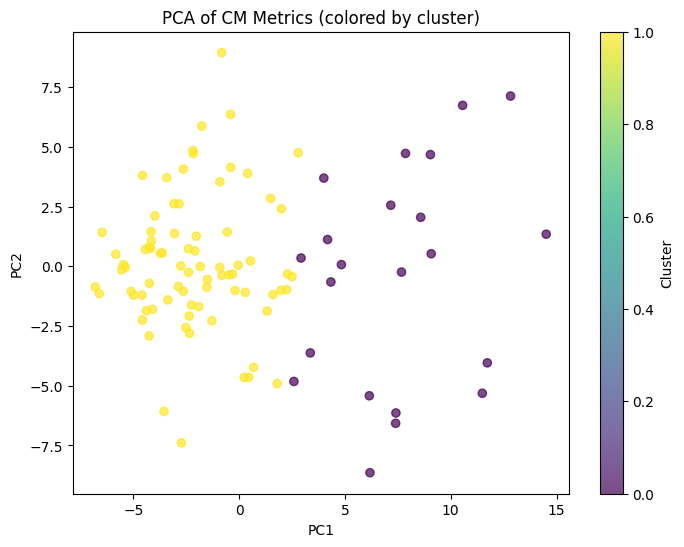

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_cm_pca = pca.fit_transform(X_cm_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_cm_pca[:,0], X_cm_pca[:,1], c=cm_df['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of CM Metrics (colored by cluster)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [40]:
# Show the mean value of each metric for each cluster
cluster_profiles = cm_df.groupby('Cluster')[cm_metrics].mean()
display(cluster_profiles)

,Age,Market value,Matches played,Minutes played,Goals,xG,Assists,xA,Duels per 90,"Duels won, %",...,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
Cluster,,,,,,,,,,,,,,,,,,,,,
0,25.545455,4.877273e+07,24.409091,1908.863636,4.954545,4.863636,3.681818,3.645000,18.163636,43.745455,...,0.0,0.447727,0.0,0.0,0.580000,0.125455,13.109545,1.555455,0.772727,21.590909
1,26.410256,2.345128e+07,21.846154,1537.512821,1.102564,1.348333,0.935897,1.222051,16.001923,50.975769,...,0.0,0.750769,0.0,0.0,0.229872,0.022051,4.914487,0.587436,0.012821,0.000000


In [41]:
for cluster in range(best_n):
    print(f"\nCluster {cluster}:")
    display(cm_df[cm_df['Cluster'] == cluster][['Player', 'Team', 'Minutes played'] + cm_metrics[:5]])  # Show first 5 metrics for brevity


Cluster 0:


,Player,Team,Minutes played,Age,Market value,Matches played,Minutes played,Goals
1,P. Foden,Manchester City,1771,24.0,150000000,24,1771,7
5,M. Ødegaard,Arsenal,1856,26.0,110000000,21,1856,2
9,C. Palmer,Chelsea,2701,22.0,80000000,28,2701,14
13,D. Szoboszlai,Liverpool,2166,24.0,75000000,27,2166,5
16,E. Fernández,Chelsea,2385,24.0,75000000,27,2385,4
17,J. Maddison,Tottenham Hotspur,1676,28.0,70000000,27,1676,9
18,Bruno Fernandes,Manchester United,2620,30.0,70000000,28,2620,8
23,Bernardo Silva,Manchester City,2246,30.0,70000000,26,2246,2
31,Lucas Paquetà,West Ham United,1975,27.0,65000000,25,1975,4
39,D. Kulusevski,Tottenham Hotspur,2400,24.0,55000000,27,2400,7



Cluster 1:


,Player,Team,Minutes played,Age,Market value,Matches played,Minutes played,Goals
4,D. Rice,Arsenal,2368,26.0,120000000,27,2368,2
6,Bruno Guimarães,Newcastle United,2639,27.0,85000000,28,2639,3
14,A. Mac Allister,Liverpool,2304,26.0,75000000,28,2304,3
15,M. Caicedo,Chelsea,2822,23.0,75000000,29,2822,1
38,K. Mainoo,Manchester United,1382,19.0,55000000,18,1382,0
...,...,...,...,...,...,...,...,...
468,L. Bergvall,Tottenham Hotspur,1077,19.0,0,22,1077,0
484,C. Baleba,Brighton,2125,21.0,0,25,2125,2
487,E. Anderson,Nottingham Forest,2131,22.0,0,28,2131,1
489,Mateus Fernandes,Southampton,2350,20.0,0,27,2350,1
